In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# ==== YOUR FILES ====
PATIENT_EXPR_PATH = "/content/drive/MyDrive/genesExpression/RABC13_Level3.txt"

# CSV with: main_gene, indirectly_affected_gene
IMMUNE_MAP_PATH = "/content/drive/MyDrive/immune_gene_network.csv"

# PRISM (secondary screen)
PRISM_DOSE_RESPONSE_PATH = "/content/drive/MyDrive/prisma ds/secondary-screen-dose-response-curve-parameters.csv"
PRISM_CELL_LINE_INFO_PATH = "/content/drive/MyDrive/prisma ds/secondary-screen-cell-line-info.csv"
PRISM_TREATMENT_INFO_PATH = "/content/drive/MyDrive/prisma ds/secondary-screen-replicate-collapsed-treatment-info.csv"

# CCLE expression (your file)
CCLE_EXPR_PATH = "/content/drive/MyDrive/prisma ds/CCLE_expression.csv"

Load patient gene expression matrix

1.   List item
2.   List item



In [4]:
df = pd.read_csv(PATIENT_EXPR_PATH, sep="\t")
print("raw shape:", df.shape)
print(df.columns[:10])

# Detect gene column (common names)
gene_candidates = ["Gene", "gene", "Hugo_Symbol", "HGNC", "symbol", "NAME"]
gene_col = next((c for c in gene_candidates if c in df.columns), df.columns[0])

# numeric sample columns = everything except gene column
numeric_cols = [c for c in df.columns if c != gene_col]
print("gene_col:", gene_col)
print("num samples:", len(numeric_cols))

# Build matrix: rows = genes, cols = patients/samples
work = df[[gene_col] + numeric_cols].copy()
work = work.dropna(subset=[gene_col]).drop_duplicates(subset=[gene_col])

mat = work[numeric_cols].apply(pd.to_numeric, errors="coerce")
mat.index = (
    work[gene_col].astype(str)
    .str.upper()
    .str.replace(r"\.\d+$", "", regex=True)
    .str.strip()
)

print("matrix shape (genes x samples):", mat.shape)


raw shape: (19921, 100)
Index(['symbol', 'GSM1381406', 'GSM1381407', 'GSM1381408', 'GSM1381430',
       'GSM1381431', 'GSM1381432', 'GSM1381433', 'GSM1381524', 'GSM1381525'],
      dtype='object')
gene_col: symbol
num samples: 99
matrix shape (genes x samples): (19921, 99)


Pick ONE patient + compute z-scores vs cohort

In [5]:
patient_sample = numeric_cols[5]
patient_vec = mat[patient_sample]

mu = mat.mean(axis=1)
sd = mat.std(axis=1).replace(0, np.nan)
z = ((patient_vec - mu) / sd).dropna()

print("patient:", patient_sample)
print("z-score genes:", z.shape[0])

# quick look
z.sort_values(ascending=False).head(10), z.sort_values().head(10)


patient: GSM1381432
z-score genes: 19921


(symbol
 HAPLN1      8.021068
 HS6ST2      8.012742
 GPR1        7.306492
 MAP1LC3C    7.062063
 ST6GAL2     6.988697
 MMP13       6.824175
 SHROOM2     6.694880
 PABPC5      6.211914
 MGC4473     6.211206
 SEMA3E      6.198313
 dtype: float64,
 symbol
 SLCO1B3   -5.851328
 BCL2A1    -5.235393
 PLAC8     -5.160899
 CD52      -4.985405
 CD48      -4.830875
 SELL      -4.829083
 GNAO1     -4.618112
 S100A8    -4.593339
 TTLL2     -4.523448
 KCNK10    -4.492608
 dtype: float64)

Load immune map CSV + build patient signature genes

In [6]:
imap = pd.read_csv(IMMUNE_MAP_PATH)
imap.columns = [c.strip() for c in imap.columns]

# normalize symbols
imap["main_gene"] = imap["main_gene"].astype(str).str.upper().str.strip()
imap["indirectly_affected_gene"] = imap["indirectly_affected_gene"].astype(str).str.upper().str.strip()

main_genes = sorted(imap["main_gene"].dropna().unique().tolist())
indirect_genes = sorted(imap["indirectly_affected_gene"].dropna().unique().tolist())

signature_genes = sorted(set(main_genes) | set(indirect_genes))

print("main genes:", len(main_genes))
print("indirect genes:", len(indirect_genes))
print("signature genes total:", len(signature_genes))

# keep only genes that exist in your patient matrix
signature_genes_in_expr = [g for g in signature_genes if g in z.index]
print("signature genes found in expr:", len(signature_genes_in_expr))


main genes: 79
indirect genes: 65
signature genes total: 144
signature genes found in expr: 137


Patient signature vector (features)

In [7]:
patient_signature = z.loc[signature_genes_in_expr].to_frame("zscore")
patient_signature["gene"] = patient_signature.index
patient_signature = patient_signature[["gene", "zscore"]].reset_index(drop=True)
patient_signature.head(10)


,gene,zscore
0,AICDA,-1.901968
1,B2M,-0.772951
2,BANK1,-0.542323
3,BAX,-2.386178
4,BCL10,-3.326631
5,BCL2,-1.332025
6,BLK,-2.160351
7,BST2,-1.042371
8,BTK,-1.856863
9,C1QA,2.560194


DGIdb interactions for your signature genes (dgipy)

In [8]:
!pip -q install "dgipy==0.1.0" "gql[requests]==3.5.0"

import dgipy

def chunk_list(lst, n=50):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

parts = []
for glist in chunk_list(signature_genes_in_expr, 50):
    res = dgipy.get_interactions(terms=glist, search="genes")
    parts.append(pd.DataFrame(res))

interactions = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
print("DGIdb interaction rows:", len(interactions))
print("columns:", interactions.columns.tolist())
interactions.head()


DGIdb interaction rows: 2512
columns: ['gene_name', 'gene_concept_id', 'gene_long_name', 'drug_name', 'drug_concept_id', 'drug_approved', 'interaction_score', 'interaction_attributes', 'interaction_sources', 'interaction_pmids']


,gene_name,gene_concept_id,gene_long_name,drug_name,drug_concept_id,drug_approved,interaction_score,interaction_attributes,interaction_sources,interaction_pmids
0,CXCR3,hgnc:4540,C-X-C motif chemokine receptor 3,ENARODUSTAT,ncit:C169944,False,4.350317,"{'Endogenous Drug': ['false'], 'Assay Details'...",[GuideToPharmacology],[]
1,CXCR3,hgnc:4540,C-X-C motif chemokine receptor 3,COMPOUND 6EE [PMID: 22364528],iuphar.ligand:8796,False,2.900211,"{'Endogenous Drug': ['false'], 'Assay Details'...",[GuideToPharmacology],[]
2,CXCR3,hgnc:4540,C-X-C motif chemokine receptor 3,IOX1,iuphar.ligand:8230,False,2.175158,"{'Endogenous Drug': ['false'], 'Assay Details'...",[GuideToPharmacology],[]
3,CXCR3,hgnc:4540,C-X-C motif chemokine receptor 3,VADADUSTAT,rxcui:2679296,True,1.740127,"{'Endogenous Drug': ['false'], 'Assay Details'...",[GuideToPharmacology],[]
4,CXCR3,hgnc:4540,C-X-C motif chemokine receptor 3,DDO-3055,iuphar.ligand:12785,False,8.700633,"{'Endogenous Drug': ['false'], 'Assay Details'...",[GuideToPharmacology],[]


Build a simple “drug score” (targets main genes higher)

In [9]:
# Expected columns often include something like: drug_name, gene_name (may vary)
# We'll detect columns robustly:
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

drug_col = pick_col(interactions, ["drug_name", "drug", "name"])
gene_col2 = pick_col(interactions, ["gene_name", "gene", "name"])

if drug_col is None or gene_col2 is None:
    raise ValueError("Could not detect drug/gene columns from DGIdb response. Print interactions.columns and adjust candidates.")

interactions[gene_col2] = interactions[gene_col2].astype(str).str.upper().str.strip()

# Weight main genes = 2, indirect genes = 1
main_set = set(main_genes)
ind_set = set(indirect_genes)

def gene_weight(g):
    if g in main_set: return 2
    if g in ind_set: return 1
    return 0

interactions["gene_weight"] = interactions[gene_col2].map(gene_weight)

drug_scores = (
    interactions.groupby(drug_col)
    .agg(
        n_interactions=("gene_weight", "size"),
        weighted_targets=("gene_weight", "sum"),
        n_main_targets=("gene_weight", lambda x: int((x==2).sum()))
    )
    .reset_index()
    .sort_values(["n_main_targets", "weighted_targets", "n_interactions"], ascending=False)
)

drug_scores.head(20)


,drug_name,n_interactions,weighted_targets,n_main_targets
899,INFLIXIMAB,12,23,11
69,ALDESLEUKIN,11,21,10
696,ETANERCEPT,10,18,8
1237,PEGINTERFERON ALFA-2B,10,18,8
1390,RIBAVIRIN,11,18,7
164,ATORVASTATIN CALCIUM TRIHYDRATE,8,15,7
51,ADALIMUMAB,7,14,7
97,AMOXICILLIN ANHYDROUS,7,13,6
1535,THALIDOMIDE,7,13,6
318,CARBAMAZEPINE,6,12,6


Load PRISM + CCLE expression (for IC50 model)

In [10]:
import pandas as pd
import numpy as np

# Fix mixed dtype warning by forcing some columns to string + low_memory=False
dtype_fix = {
    "phase": "string",
    "disease.area": "string",
    "target": "string",
    "moa": "string",
    "smiles": "string",
    "indication": "string",
    "broad_id": "string",
    "name": "string",
    "screen_id": "string",
}

prism = pd.read_csv(PRISM_DOSE_RESPONSE_PATH, low_memory=False, dtype=dtype_fix)

print("prism shape:", prism.shape)
print("prism columns:", prism.columns.tolist())

# Required columns per PRISM secondary screen README:
required = ["depmap_id", "name", "ic50"]
missing = [c for c in required if c not in prism.columns]
if missing:
    raise ValueError(f"Missing required PRISM columns: {missing}. "
                     f"Your file columns are: {prism.columns.tolist()}")

# Optional but recommended by README: prefer screen_id == 'MTS010' when available
if "screen_id" in prism.columns:
    prism["__is_mts010"] = (prism["screen_id"].astype(str) == "MTS010").astype(int)
    prism = prism.sort_values("__is_mts010", ascending=False)

    # if multiple screens exist for same drug/cell line, keep MTS010 row first
    prism = prism.drop_duplicates(subset=["depmap_id", "name"], keep="first").drop(columns="__is_mts010")

print("after de-dup:", prism.shape)


prism shape: (701004, 20)
prism columns: ['broad_id', 'depmap_id', 'ccle_name', 'screen_id', 'upper_limit', 'lower_limit', 'slope', 'r2', 'auc', 'ec50', 'ic50', 'name', 'moa', 'target', 'disease.area', 'indication', 'smiles', 'phase', 'passed_str_profiling', 'row_name']
after de-dup: (625541, 20)


Map treatment_id → drug name, prepare one-drug training table

In [11]:
# Minimal training table (drug_name already inside PRISM file)
pr = prism[["depmap_id", "name", "ic50"]].copy()
pr.columns = ["depmap_id", "drug_name", "ic50_value"]

# Clean
pr["drug_name"] = pr["drug_name"].astype(str).str.strip()
pr["ic50_value"] = pd.to_numeric(pr["ic50_value"], errors="coerce")
pr = pr.dropna(subset=["depmap_id", "drug_name", "ic50_value"])

print("training table pr shape:", pr.shape)
pr.head()


training table pr shape: (310324, 3)


,depmap_id,drug_name,ic50_value
658208,ACH-000411,abemaciclib,0.674168
668909,ACH-000587,SCH-900776,5.130275
658201,ACH-000411,resminostat,1.992925
658195,ACH-000411,napabucasin,0.595475
658192,ACH-000411,saracatinib,0.565282


Load CCLE expression and align features to signature genes

In [12]:
ccle = pd.read_csv(CCLE_EXPR_PATH, low_memory=False)
print("CCLE shape:", ccle.shape)
print("CCLE columns head:", list(ccle.columns[:5]))

# DepMap IDs should be in the FIRST COLUMN VALUES
first_col = ccle.columns[0]
ccle[first_col] = ccle[first_col].astype(str).str.strip().str.upper()

# Check DepMap IDs exist in first column values
ach_in_first = ccle[first_col].head(300).str.startswith("ACH-").sum()
print("ACH in first column (first 300 rows):", ach_in_first)

if ach_in_first < 100:
    raise ValueError("This CCLE file does not have ACH- IDs in the first column values. Print ccle.head().")

ccle_mat = ccle.set_index(first_col)
ccle_mat.index.name = "depmap_id"

# Clean gene columns: "TSPAN6 (7105)" -> "TSPAN6"
ccle_mat.columns = [str(c).split("(")[0].strip().upper() for c in ccle_mat.columns]
ccle_mat = ccle_mat.apply(pd.to_numeric, errors="coerce")

print("CCLE final:", ccle_mat.shape)
print("CCLE index sample:", list(ccle_mat.index[:10]))


CCLE shape: (1406, 19222)
CCLE columns head: ['Unnamed: 0', 'TSPAN6 (7105)', 'TNMD (64102)', 'DPM1 (8813)', 'SCYL3 (57147)']
ACH in first column (first 300 rows): 300
CCLE final: (1406, 19221)
CCLE index sample: ['ACH-001113', 'ACH-001289', 'ACH-001339', 'ACH-001538', 'ACH-000242', 'ACH-000708', 'ACH-000327', 'ACH-000233', 'ACH-000461', 'ACH-000705']


In [13]:
pr["depmap_id"] = pr["depmap_id"].astype(str).str.strip().str.upper()
ccle_mat.index = ccle_mat.index.astype(str).str.strip().str.upper()

overlap = set(pr["depmap_id"]).intersection(set(ccle_mat.index))
print("OVERLAP:", len(overlap))
if len(overlap) == 0:
    raise ValueError("Overlap is still 0. Stop and fix CCLE orientation before training.")


OVERLAP: 476


In [14]:
genes_for_model = [g for g in signature_genes_in_expr if g in ccle_mat.columns]
print("genes_for_model:", len(genes_for_model))
print("example:", genes_for_model[:10])


genes_for_model: 137
example: ['AICDA', 'B2M', 'BANK1', 'BAX', 'BCL10', 'BCL2', 'BLK', 'BST2', 'BTK', 'C1QA']


In [15]:
pr["drug_name"] = pr["drug_name"].astype(str)
pr["drug_norm"] = pr["drug_name"].str.strip().str.lower()
print("cisplatin rows in pr:", (pr["drug_norm"] == "cisplatin").sum())


cisplatin rows in pr: 299


In [16]:
d = pr[pr["drug_norm"] == "cisplatin"].copy()
print("cisplatin BEFORE CCLE filter:", len(d))

d["depmap_id"] = d["depmap_id"].astype(str).str.strip().str.upper()
print("cisplatin AFTER  CCLE filter:", (d["depmap_id"].isin(ccle_mat.index)).sum())

cisplatin BEFORE CCLE filter: 299
cisplatin AFTER  CCLE filter: 296


Train IC50 model for ONE drug (log IC50 + row-wise z)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

def rowwise_z(df: pd.DataFrame) -> pd.DataFrame:
    m = df.mean(axis=1)
    s = df.std(axis=1).replace(0, np.nan)
    return df.sub(m, axis=0).div(s, axis=0)

def train_one_drug_ic50(prism_drug_name, min_rows=80, max_rows=20000):
    drug = str(prism_drug_name).strip().lower()

    d = pr[pr["drug_norm"] == drug].copy()
    print(drug, "rows before CCLE filter =", len(d))

    d["depmap_id"] = d["depmap_id"].astype(str).str.strip().str.upper()
    d = d[d["depmap_id"].isin(ccle_mat.index)]
    print(drug, "rows after  CCLE filter =", len(d))

    if len(d) < min_rows:
        print(f"Too few rows for {drug}: {len(d)} (need >= {min_rows})")
        return None




    # Downsample very large drugs for speed
    if len(d) > max_rows:
        d = d.sample(n=max_rows, random_state=7)
        d = d.reset_index(drop=True)

    X = ccle_mat.loc[d["depmap_id"], genes_for_model].copy()
    X = X.fillna(X.mean())
    X = rowwise_z(X).fillna(0.0)
    # Make sure ic50_value is numeric
    d["ic50_value"] = pd.to_numeric(d["ic50_value"], errors="coerce")

    # Keep only positive values (log needs > 0)
    d = d[d["ic50_value"].notna() & (d["ic50_value"] > 0)]

    # Convert to float array then take log
    y = np.log(d["ic50_value"].to_numpy(dtype=float))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    model = ElasticNet(alpha=0.01, l1_ratio=0.2, random_state=7, max_iter=5000)
    model.fit(X_train_s, y_train)

    pred = model.predict(X_test_s)
    mae = float(mean_absolute_error(y_test, pred))
    r2 = float(r2_score(y_test, pred))

    print(f"PRISM Drug: {prism_drug_name} | n={len(X)} | MAE(logIC50)={mae:.4f} | R2={r2:.4f}")
    return model, scaler, {"n": int(len(X)), "mae_log": mae, "r2": r2}


In [18]:

trained = train_one_drug_ic50("cisplatin", min_rows=80, max_rows=20000)
trained

cisplatin rows before CCLE filter = 299
cisplatin rows after  CCLE filter = 296
PRISM Drug: cisplatin | n=296 | MAE(logIC50)=0.3143 | R2=-0.8832


(ElasticNet(alpha=0.01, l1_ratio=0.2, max_iter=5000, random_state=7),
 StandardScaler(),
 {'n': 296, 'mae_log': 0.3143203773786348, 'r2': -0.8831857809314487})

inspect for prism naming

In [19]:
print("PRISM unique drug names:", pr["drug_name"].nunique())
print("PRISM sample names:", pr["drug_name"].dropna().astype(str).str.strip().drop_duplicates().head(30).tolist())

# Search for 'cis' to see what PRISM calls cisplatin-like entries (if any)
pr[pr["drug_name"].astype(str).str.lower().str.contains("cis", na=False)][["drug_name"]].drop_duplicates().head(50)


PRISM unique drug names: 1415
PRISM sample names: ['abemaciclib', 'SCH-900776', 'resminostat', 'napabucasin', 'saracatinib', 'belinostat', 'MLN0128', 'dacomitinib', 'MK-1775', 'P276-00', 'palbociclib', 'poziotinib', 'dasatinib', 'daunorubicin', 'carfilzomib', 'NVP-BEZ235', 'carmofur', 'pelitinib', 'I-BET-762', 'XL-647', 'panobinostat', 'pralatrexate', 'gambogic-acid', 'GDC-0980', 'obatoclax', 'LY2603618', 'dinaciclib', 'AT-7519', 'trametinib', 'BIIB021']


,drug_name
587422,cisplatin
272813,cobicistat


In [20]:
test_name = "CISPLATIN"  # from your DGIdb list

# Show if there are hidden characters in DGIdb string
print("DGIdb repr:", repr(test_name))

# Try matching in PRISM with robust normalize
pr_names_norm = pr["drug_name"].astype(str).str.strip().str.lower()
hits = (pr_names_norm == str(test_name).strip().lower()).sum()

print("Hits in PRISM (strip+lower):", hits)

# If hits is 0, show closest PRISM names
if hits == 0:
    import difflib
    candidates = pr["drug_name"].dropna().astype(str).str.strip().drop_duplicates().tolist()
    print("Closest PRISM matches:", difflib.get_close_matches(test_name.lower(), candidates, n=10, cutoff=0.6))


DGIdb repr: 'CISPLATIN'
Hits in PRISM (strip+lower): 299


Normalize DGIdb drug names and map them to PRISM names

In [21]:
import re
import pandas as pd
import numpy as np

# PRISM canonical names (lowercase)
prism_name_set = set(pr["drug_name"].astype(str).str.strip().str.lower().unique())

def norm_basic(x):
    return str(x).strip().lower()

# OPTIONAL: remove common salt/hydrate tokens to improve matching
DROP_TOKENS = [
    "anhydrous", "trihydrate", "dihydrate", "monohydrate", "hydrate",
    "calcium", "sodium", "potassium", "magnesium",
    "hydrochloride", "hcl", "chloride",
    "phosphate", "sulfate", "sulphate", "acetate",
    "succinate", "tartrate", "maleate", "mesylate", "besylate",
    "fumarate", "citrate", "lactate", "carbonate", "oxalate",
    "hemihydrate"
]
DROP_RE = re.compile(r"\b(" + "|".join(map(re.escape, DROP_TOKENS)) + r")\b", flags=re.IGNORECASE)

def norm_strong(x):
    s = str(x).lower().strip()
    s = re.sub(r"\(.*?\)", " ", s)      # remove (...) text
    s = DROP_RE.sub(" ", s)             # drop salt/hydrate words
    s = re.sub(r"[^a-z0-9]+", " ", s)   # remove punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s

drug_name_col = drug_scores.columns[0]

# Build both norms for DGIdb list
drug_scores["dgidb_norm_basic"] = drug_scores[drug_name_col].map(norm_basic)
drug_scores["dgidb_norm_strong"] = drug_scores[drug_name_col].map(norm_strong)

# Direct match attempt 1: basic
drug_scores["prism_match"] = drug_scores["dgidb_norm_basic"].where(
    drug_scores["dgidb_norm_basic"].isin(prism_name_set),
    other=np.nan
)

# Direct match attempt 2: strong norm -> basic PRISM name
drug_scores.loc[drug_scores["prism_match"].isna(), "prism_match"] = drug_scores.loc[
    drug_scores["prism_match"].isna(), "dgidb_norm_strong"
].where(
    drug_scores.loc[drug_scores["prism_match"].isna(), "dgidb_norm_strong"].isin(prism_name_set),
    other=np.nan
)

# Count PRISM rows per matched drug
pr_counts = pr["drug_name"].astype(str).str.strip().str.lower().value_counts()
drug_scores["prism_rows"] = drug_scores["prism_match"].map(pr_counts).fillna(0).astype(int)

print("DGIdb drugs:", len(drug_scores))
print("Matched to PRISM:", drug_scores["prism_match"].notna().sum())
print("Top matched examples:")
drug_scores[drug_scores["prism_match"].notna()][[drug_name_col, "prism_match", "prism_rows"]].head(20)


DGIdb drugs: 1706
Matched to PRISM: 199
Top matched examples:


,drug_name,prism_match,prism_rows
1390,RIBAVIRIN,ribavirin,5
164,ATORVASTATIN CALCIUM TRIHYDRATE,atorvastatin,175
97,AMOXICILLIN ANHYDROUS,amoxicillin,17
454,CISPLATIN,cisplatin,299
541,CYCLOPHOSPHAMIDE ANHYDROUS,cyclophosphamide,122
542,CYCLOSPORINE,cyclosporine,59
155,ASPIRIN,aspirin,117
1167,NVP-TAE684,nvp-tae684,431
632,DOVITINIB,dovitinib,110
1257,PF-562271,pf-562271,414


In [22]:
MIN_ROWS = 80  # start with 80, raise later if you want

trainable = drug_scores[
    drug_scores["prism_match"].notna() & (drug_scores["prism_rows"] >= MIN_ROWS)
].copy()

not_in_prism = drug_scores[drug_scores["prism_match"].isna()].copy()

print("Trainable (in PRISM, enough rows):", len(trainable))
print("Not in PRISM (IC50 impossible here):", len(not_in_prism))

trainable[[drug_name_col, "prism_match", "prism_rows", "n_main_targets", "weighted_targets"]].head(30)


Trainable (in PRISM, enough rows): 150
Not in PRISM (IC50 impossible here): 1507


,drug_name,prism_match,prism_rows,n_main_targets,weighted_targets
164,ATORVASTATIN CALCIUM TRIHYDRATE,atorvastatin,175,7,15
454,CISPLATIN,cisplatin,299,5,14
541,CYCLOPHOSPHAMIDE ANHYDROUS,cyclophosphamide,122,5,13
155,ASPIRIN,aspirin,117,4,11
1167,NVP-TAE684,nvp-tae684,431,4,11
632,DOVITINIB,dovitinib,110,4,10
1257,PF-562271,pf-562271,414,4,10
1581,TOZASERTIB,tozasertib,126,4,10
978,LAPATINIB,lapatinib,90,4,8
556,DASATINIB ANHYDROUS,dasatinib,179,3,9


Predict patient IC50 for a trained drug

In [23]:
# normalize gene symbols
patient_vec = patient_vec.copy()
patient_vec.index = patient_vec.index.astype(str).str.strip().str.upper()

# aggregate duplicates (mean is the safest default)
patient_vec = patient_vec.groupby(level=0).mean()

print("After dedup -> length:", len(patient_vec), "unique:", patient_vec.index.nunique())


After dedup -> length: 19920 unique: 19920


In [24]:
def predict_patient_ic50(model, scaler):
    pv = patient_vec.copy()

    # ensure clean index + no duplicates
    pv.index = pv.index.astype(str).str.strip().str.upper()
    if pv.index.duplicated().any():
        pv = pv.groupby(level=0).mean()

    gf = [str(g).strip().upper() for g in genes_for_model]
    gf = list(dict.fromkeys(gf))

    x_patient = pv.reindex(gf)
    x_patient = pd.to_numeric(x_patient, errors="coerce")

    mean_val = float(np.nanmean(x_patient.values)) if np.isfinite(np.nanmean(x_patient.values)) else 0.0
    x_patient = x_patient.fillna(mean_val)

    Xp = pd.DataFrame([x_patient.values], columns=gf)
    Xp = rowwise_z(Xp).fillna(0.0)

    pred_log_ic50 = float(model.predict(scaler.transform(Xp))[0])
    pred_ic50 = float(np.exp(pred_log_ic50))
    return pred_ic50, pred_log_ic50


In [25]:
main_set = set(imap["main_gene"].astype(str).str.upper().str.strip())
ind_set  = set(imap["indirectly_affected_gene"].astype(str).str.upper().str.strip())

sig_set = set(signature_genes_in_expr)  # what you actually used

print("Main genes in signature:", len(sig_set & main_set))
print("Indirect genes in signature:", len(sig_set & ind_set))
print("Signature total:", len(sig_set))


Main genes in signature: 76
Indirect genes in signature: 61
Signature total: 137


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def rowwise_z(df: pd.DataFrame) -> pd.DataFrame:
    m = df.mean(axis=1)
    s = df.std(axis=1).replace(0, np.nan)
    return df.sub(m, axis=0).div(s, axis=0)

def train_one_drug_ic50(prism_drug_name, min_rows=80, max_rows=20000):
    drug = str(prism_drug_name).strip().lower()

    d = pr[pr["drug_norm"] == drug].copy()
    print(drug, "rows before CCLE filter =", len(d))

    # --- clean depmap ids first ---
    d = d.dropna(subset=["depmap_id", "ic50_value"])
    d["depmap_id"] = d["depmap_id"].astype(str).str.strip().str.upper()

    # keep only rows that exist in CCLE
    d = d[d["depmap_id"].isin(ccle_mat.index)]
    print(drug, "rows after  CCLE filter =", len(d))

    # --- clean ic50 BEFORE building X ---
    d["ic50_value"] = pd.to_numeric(d["ic50_value"], errors="coerce")
    d = d[d["ic50_value"].notna() & (d["ic50_value"] > 0)]

    # optional: if same depmap_id appears multiple times for a drug, average ic50 per cell line
    # (this usually improves stability)
    d = d.groupby("depmap_id", as_index=False)["ic50_value"].mean()

    if len(d) < min_rows:
        print(f"Too few rows for {drug}: {len(d)} (need >= {min_rows})")
        return None

    # Downsample for speed
    if len(d) > max_rows:
        d = d.sample(n=max_rows, random_state=7).reset_index(drop=True)

    # --- now build X aligned exactly to filtered d ---
    X = ccle_mat.loc[d["depmap_id"], genes_for_model].copy()
    X = X.fillna(X.mean())
    X = rowwise_z(X).fillna(0.0)

    y = np.log(d["ic50_value"].to_numpy(dtype=float))

    # final safety check
    if len(X) != len(y):
        raise ValueError(f"Alignment bug: X={len(X)} rows, y={len(y)} rows for drug={drug}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=7
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    model = ElasticNet(alpha=0.01, l1_ratio=0.2, random_state=7, max_iter=5000)
    model.fit(X_train_s, y_train)

    pred = model.predict(X_test_s)
    mae = float(mean_absolute_error(y_test, pred))
    r2 = float(r2_score(y_test, pred))

    print(f"PRISM Drug: {drug} | n={len(X)} | MAE(logIC50)={mae:.4f} | R2={r2:.4f}")
    return model, scaler, {"n": int(len(X)), "mae_log": mae, "r2": r2}


Train + predict for TOP drugs and rank (DGIdb score + predicted IC50)

In [27]:
results = []
TOP_N = 50

# Select top N drugs to evaluate
cands = trainable.head(TOP_N).copy()

for _, row in cands.iterrows():
    prism_name = str(row["prism_match"]).strip().lower()  # ensure clean string

    # Train the model for this drug
    trained = train_one_drug_ic50(prism_name, min_rows=MIN_ROWS, max_rows=20000)

    if trained is None:
        continue

    model, scaler, metrics = trained
    ic50_pred, log_ic50_pred = predict_patient_ic50(model, scaler)

    # Only append the results if the R² is greater than -1.4
    r2_value = metrics["r2"]
    if r2_value >= -1.4:
        out = row.to_dict()
        out.update({
            "used_prism_name": prism_name,
            "pred_ic50": ic50_pred,
            "pred_log_ic50": log_ic50_pred,
            "train_n": metrics["n"],
            "model_mae_log": metrics["mae_log"],
            "model_r2": r2_value,
        })
        results.append(out)

# After collecting all the results, convert them into a DataFrame
ranked_ic50 = pd.DataFrame(results)

if ranked_ic50.empty:
    print("No models trained or no models with R² >= -1.4. ranked_ic50 is empty.")
else:
    # Step 1: Filter out rows where R² < -1.4 after creating the DataFrame
    ranked_ic50 = ranked_ic50[ranked_ic50["model_r2"] >= -1.4]

    # Sort the results by the final score
    ranked_ic50 = ranked_ic50.sort_values(
        ["n_main_targets", "weighted_targets", "pred_ic50"],
        ascending=[False, False, True]
    ).reset_index(drop=True)

    # Only show columns that actually exist (prevents KeyError)
    cols_to_show = [drug_name_col, "used_prism_name", "prism_rows", "pred_ic50", "train_n", "model_r2"]
    cols_to_show = [c for c in cols_to_show if c in ranked_ic50.columns]

    print("Showing columns:", cols_to_show)
    print(ranked_ic50[cols_to_show].head(30))


atorvastatin rows before CCLE filter = 175
atorvastatin rows after  CCLE filter = 173
PRISM Drug: atorvastatin | n=173 | MAE(logIC50)=5.5714 | R2=-105.9527
cisplatin rows before CCLE filter = 299
cisplatin rows after  CCLE filter = 296
PRISM Drug: cisplatin | n=296 | MAE(logIC50)=0.3705 | R2=-1.5677
cyclophosphamide rows before CCLE filter = 122
cyclophosphamide rows after  CCLE filter = 121
PRISM Drug: cyclophosphamide | n=121 | MAE(logIC50)=3.6643 | R2=-101.4371
aspirin rows before CCLE filter = 117
aspirin rows after  CCLE filter = 115
PRISM Drug: aspirin | n=114 | MAE(logIC50)=4.6168 | R2=-1.5779
nvp-tae684 rows before CCLE filter = 431
nvp-tae684 rows after  CCLE filter = 427
PRISM Drug: nvp-tae684 | n=427 | MAE(logIC50)=0.6328 | R2=-0.4515
dovitinib rows before CCLE filter = 110
dovitinib rows after  CCLE filter = 109
PRISM Drug: dovitinib | n=109 | MAE(logIC50)=1.8184 | R2=-1.9714
pf-562271 rows before CCLE filter = 414
pf-562271 rows after  CCLE filter = 410
PRISM Drug: pf-5622

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.795e-02, tolerance: 1.830e-02
  model = cd_fast.enet_coordinate_descent(


PRISM Drug: lapatinib | n=90 | MAE(logIC50)=1.1946 | R2=-2.4418
dasatinib rows before CCLE filter = 179
dasatinib rows after  CCLE filter = 178
PRISM Drug: dasatinib | n=178 | MAE(logIC50)=2.9160 | R2=-2.8097
imatinib rows before CCLE filter = 88
imatinib rows after  CCLE filter = 88
PRISM Drug: imatinib | n=88 | MAE(logIC50)=2.1585 | R2=-5.0411
paclitaxel rows before CCLE filter = 264
paclitaxel rows after  CCLE filter = 261
PRISM Drug: paclitaxel | n=261 | MAE(logIC50)=1.4168 | R2=-0.7360
mercaptopurine rows before CCLE filter = 162
mercaptopurine rows after  CCLE filter = 160
PRISM Drug: mercaptopurine | n=160 | MAE(logIC50)=0.6315 | R2=-1.7797
azathioprine rows before CCLE filter = 145
azathioprine rows after  CCLE filter = 144


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e+02, tolerance: 2.848e+00
  model = cd_fast.enet_coordinate_descent(


PRISM Drug: azathioprine | n=144 | MAE(logIC50)=23.6269 | R2=-2192.0708
erlotinib rows before CCLE filter = 102
erlotinib rows after  CCLE filter = 100
PRISM Drug: erlotinib | n=100 | MAE(logIC50)=1.7923 | R2=-3.9519
theophylline rows before CCLE filter = 353
theophylline rows after  CCLE filter = 350
PRISM Drug: theophylline | n=350 | MAE(logIC50)=0.4646 | R2=-0.8331
baricitinib rows before CCLE filter = 369
baricitinib rows after  CCLE filter = 367
PRISM Drug: baricitinib | n=367 | MAE(logIC50)=0.7540 | R2=-2.9713
midostaurin rows before CCLE filter = 456
midostaurin rows after  CCLE filter = 452
PRISM Drug: midostaurin | n=452 | MAE(logIC50)=0.5076 | R2=-0.3021
sorafenib rows before CCLE filter = 91
sorafenib rows after  CCLE filter = 89
PRISM Drug: sorafenib | n=89 | MAE(logIC50)=0.9990 | R2=-0.8283
doxorubicin rows before CCLE filter = 464
doxorubicin rows after  CCLE filter = 460
PRISM Drug: doxorubicin | n=460 | MAE(logIC50)=0.7529 | R2=-0.5625
sirolimus rows before CCLE filter 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.639e+01, tolerance: 9.260e-01
  model = cd_fast.enet_coordinate_descent(


PRISM Drug: ibrutinib | n=81 | MAE(logIC50)=10.7030 | R2=-76.9349
methotrexate rows before CCLE filter = 309
methotrexate rows after  CCLE filter = 306
PRISM Drug: methotrexate | n=306 | MAE(logIC50)=0.8677 | R2=-0.2062
mln-8054 rows before CCLE filter = 287
mln-8054 rows after  CCLE filter = 285
PRISM Drug: mln-8054 | n=285 | MAE(logIC50)=1.7663 | R2=-0.1314
digoxin rows before CCLE filter = 445
digoxin rows after  CCLE filter = 441
PRISM Drug: digoxin | n=441 | MAE(logIC50)=0.4934 | R2=-0.0497
enmd-2076 rows before CCLE filter = 315
enmd-2076 rows after  CCLE filter = 311
PRISM Drug: enmd-2076 | n=311 | MAE(logIC50)=0.6542 | R2=-0.3885
gefitinib rows before CCLE filter = 117
gefitinib rows after  CCLE filter = 115


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e-02, tolerance: 2.397e-02
  model = cd_fast.enet_coordinate_descent(


PRISM Drug: gefitinib | n=115 | MAE(logIC50)=2.8761 | R2=-5.4363
jnj-7706621 rows before CCLE filter = 417
jnj-7706621 rows after  CCLE filter = 414
PRISM Drug: jnj-7706621 | n=414 | MAE(logIC50)=0.5207 | R2=-0.3308
melphalan rows before CCLE filter = 318
melphalan rows after  CCLE filter = 314
PRISM Drug: melphalan | n=314 | MAE(logIC50)=0.5025 | R2=-0.4496
simvastatin rows before CCLE filter = 348
simvastatin rows after  CCLE filter = 345
PRISM Drug: simvastatin | n=345 | MAE(logIC50)=0.5269 | R2=-0.7775
fluvastatin rows before CCLE filter = 450
fluvastatin rows after  CCLE filter = 446
PRISM Drug: fluvastatin | n=446 | MAE(logIC50)=0.7932 | R2=-0.5884
rutin rows before CCLE filter = 202
rutin rows after  CCLE filter = 200
PRISM Drug: rutin | n=200 | MAE(logIC50)=1.7734 | R2=-5.8515
alisertib rows before CCLE filter = 405
alisertib rows after  CCLE filter = 401
PRISM Drug: alisertib | n=401 | MAE(logIC50)=1.3130 | R2=-0.5860
bortezomib rows before CCLE filter = 444
bortezomib rows af

In [28]:
import numpy as np
import pandas as pd

# Safety
assert not ranked_ic50.empty, "ranked_ic50 is empty. Train at least 1 drug first."

# Percentile-based bins (you can change these)
low_q = 0.33
high_q = 0.67

ic50_low = ranked_ic50["pred_ic50"].quantile(low_q)
ic50_high = ranked_ic50["pred_ic50"].quantile(high_q)

print("IC50 thresholds:")
print("Low  <=", ic50_low)
print("High >=", ic50_high)

def ic50_class(v):
    if pd.isna(v):
        return "Unknown"
    if v <= ic50_low:
        return "LOW (better sensitivity)"
    elif v >= ic50_high:
        return "HIGH (worse sensitivity)"
    return "MEDIUM"


IC50 thresholds:
Low  <= 0.14726553803444567
High >= 157.98822636617624


 a clean Drug Ranking Table

# Drug Ranking Table

pred_ic50: predicted sensitivity for your patient (lower = better)

ic50_class: Low/Medium/High compared to all drugs you trained

recommendation: Better / Maybe / Worse

final_score: combined score that balances targets + IC50 + model quality

How well the drug targets the patient’s genes (both direct and indirect targets)

How low the predicted IC50 is (meaning how sensitive the patient is to that drug)

Model quality: How well the system learned from the training data (R² and Mean Absolute Error values).

In [29]:
# Pick the columns you actually have
cols = ranked_ic50.columns.tolist()
drug_col = drug_name_col if drug_name_col in cols else "drug_name"

df = ranked_ic50.copy()

# Add IC50 class
df["ic50_class"] = df["pred_ic50"].apply(ic50_class)

# Normalize things into 0..1 so we can combine them
# Higher is better for target score, lower is better for IC50
def minmax(s):
    s = s.astype(float)
    if s.max() == s.min():
        return pd.Series([0.5]*len(s), index=s.index)
    return (s - s.min()) / (s.max() - s.min())

# These columns should exist based on your earlier logic
target_col = "weighted_targets" if "weighted_targets" in df.columns else None
r2_col = "model_r2" if "model_r2" in df.columns else None

# Create scoring components
if target_col:
    df["score_targets"] = minmax(df[target_col])
else:
    df["score_targets"] = 0.0

df["score_ic50"] = 1 - minmax(df["pred_ic50"])   # lower IC50 => higher score

if r2_col:
    # clamp r2 to [-1,1] then map to 0..1
    df["score_model"] = ((df[r2_col].clip(-1,1) + 1) / 2.0)
else:
    df["score_model"] = 0.5

# Final score (adjust weights as you like)
df["final_score"] = (
    0.50 * df["score_targets"] +
    0.40 * df["score_ic50"] +
    0.10 * df["score_model"]
)

# Sort best first
df = df.sort_values("final_score", ascending=False).reset_index(drop=True)

# Make a simple "better / worse" label
df["recommendation"] = np.where(df["ic50_class"].str.startswith("LOW"), "Better",
                         np.where(df["ic50_class"].str.startswith("HIGH"), "Worse", "Maybe"))

# Display a clean table
show_cols = [
    drug_col, "pred_ic50", "ic50_class", "recommendation",
    "final_score",
]
for c in ["n_main_targets", "weighted_targets", "prism_rows", "train_n", "model_r2", "model_mae_log"]:
    if c in df.columns:
        show_cols.append(c)

print("Top drugs (best first):")
df[show_cols].head(30)


#This ranks drugs by:
#Targeting strength (your weighted score)
#Lower IC50 (better)
#Model quality (R²)


Top drugs (best first):


,drug_name,pred_ic50,ic50_class,recommendation,final_score,n_main_targets,weighted_targets,prism_rows,train_n,model_r2,model_mae_log
0,NVP-TAE684,7.449262e+02,HIGH (worse sensitivity),Worse,0.927425,4,11,431,427,-0.451498,0.632802
1,TOZASERTIB,1.514936e-01,MEDIUM,Maybe,0.837500,4,10,126,125,-1.018030,1.455727
2,DOXORUBICIN HYDROCHLORIDE,3.910923e+03,HIGH (worse sensitivity),Worse,0.796870,2,9,464,460,-0.562543,0.752913
3,PACLITAXEL,2.999641e-02,LOW (better sensitivity),Better,0.788199,3,9,264,261,-0.736012,1.416845
4,SIROLIMUS,3.312610e-11,LOW (better sensitivity),Better,0.679311,2,7,426,423,-0.413779,3.098143
5,THEOPHYLLINE,2.041051e+02,HIGH (worse sensitivity),Worse,0.658346,3,7,353,350,-0.833074,0.464597
6,MLN-8054,1.650173e+04,HIGH (worse sensitivity),Worse,0.630921,2,6,287,285,-0.131385,1.766348
7,METHOTREXATE,2.035965e+00,MEDIUM,Maybe,0.627189,2,6,309,306,-0.206227,0.867685
8,MIDOSTAURIN,5.227880e+00,MEDIUM,Maybe,0.622396,3,6,456,452,-0.302073,0.507556
9,HESPERADIN,1.126372e+06,HIGH (worse sensitivity),Worse,0.617319,2,6,358,355,-0.389774,1.132315


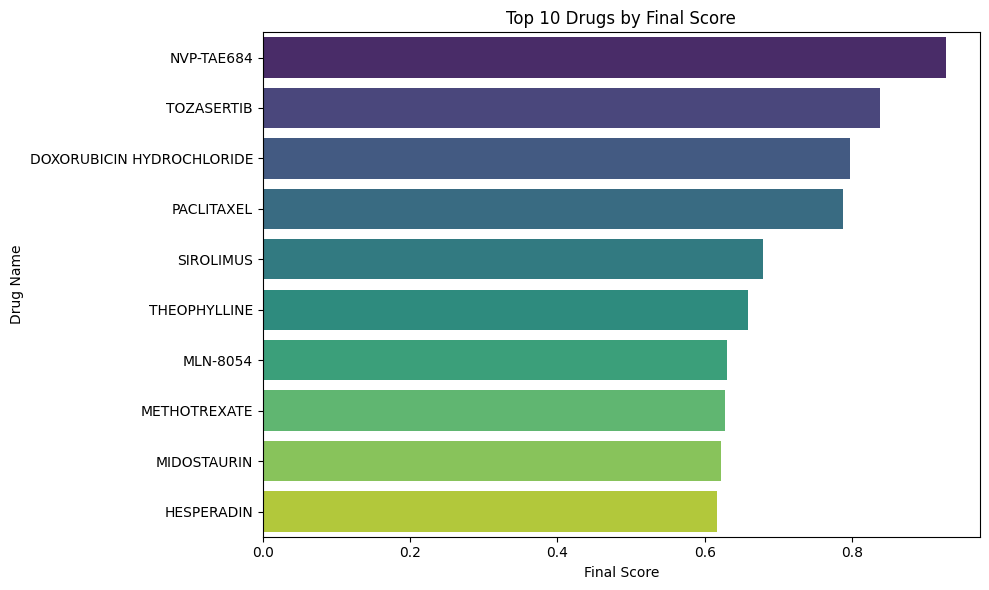

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the top N drugs to visualize (e.g., top 10)
top_n_to_plot = 10
df_to_plot = df.head(top_n_to_plot)

plt.figure(figsize=(10, 6))
sns.barplot(x="final_score", y=drug_col, data=df_to_plot, palette="viridis", hue=drug_col, legend=False)
plt.xlabel("Final Score")
plt.ylabel("Drug Name")
plt.title(f"Top {top_n_to_plot} Drugs by Final Score")
plt.tight_layout()
plt.show()